In [1]:
# 이미지분류 신경망
#LeNet-5 : 합성곱 신경망의 최초 구조
# 합성곱과 다운샘플링을 반복.. 마지막에 완전 연결층에서 분류 수행

In [ ]:
# C1에서 5x5 합성곱 연산후 28x28크기의 특성맵 여섯개 생성
# S2에서 다운 샘플링 맵 크기를 14x14로 줄임
# C3는 5x5 합성곱 연산후 10x10크기의 특성맵 16 생성

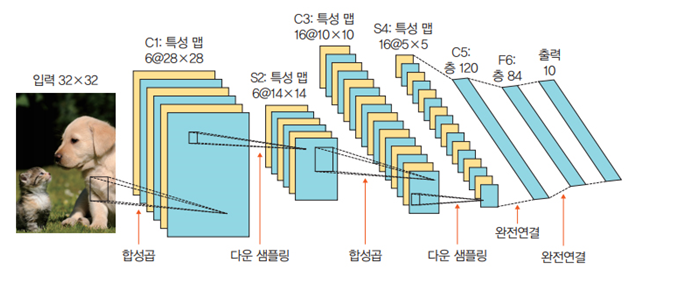

In [ ]:
# LeNet-5를 사용하는 예제
# 데이터는 개 고양이

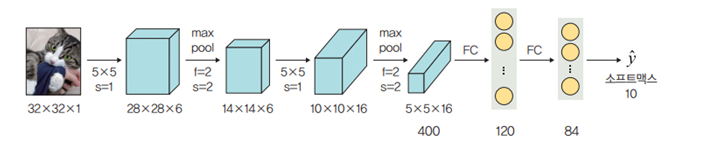

In [ ]:
# 상세 설계안

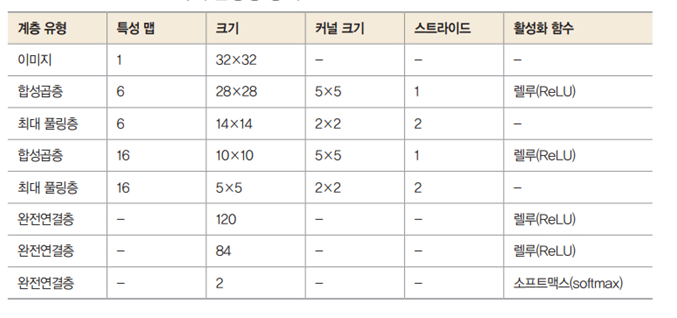

In [2]:
# 진행상황을 시각화 하기위해
!pip install --user tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
